### <font color="blue">Introduction</font> 
This is a project related to https://www.kaggle.com/donorschoose/io/home competetion and the dataset used here is also is related to it. <br>
1. **Scope of the work**: Identify the projects with their related projects. The donors are passionate about specific projects and if we can associate the projects with all the related projects, the donor can be presented with all the related projects. Given this information, the donor can make informed choices quickly.<br>
2. **Solution Approach**: The similarity can be established by comparing the “project essay”: field with projects dataset. So this is essentially a document similarity problem. I plan to use Supervised Machine learning using SVM (Support Vector Machine) for document classification.
The project proposal is available at https://github.com/gitapriyam/machine-learning/blob/first-iteration/projects/capstone/Capstone%20Proposal.pdf

#### <font color="blue">1.0 import all the required for executing the code</font> 


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from multiprocessing import Pool

# other python utilities 
from tqdm import tqdm
from tqdm import tqdm_notebook
import pandas as pd 
import numpy as np 
import warnings, math
import gc 
%matplotlib inline
# ignore the warnings 
warnings.filterwarnings('ignore')

#### <font color="blue">1.1 Set Panda Options</font> 
Utility method for setting panda options are set to display pandas dataframe

In [2]:
def set_pd_options():
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)

#### <font color="blue">1.1 Load Dataset</font> 
Load the dataset files into pandas dataframe. I am using projects dataset for the purpose of this project which resides in the io folder 

In [3]:
path = "./io/"
projects_df = pd.read_csv(path +"Projects.csv")
set_pd_options()
projects_df.head()

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,Teacher-Led,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Students at our school are still working hard ...,My students need one copy of each book in The ...,Literacy & Language,"ESL, Literacy",Grades 3-5,Books,161.26,2013-01-01,2013-05-31,Fully Funded,2013-02-06
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,Teacher-Led,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...","""Idle hands"" were something that Issac Watts s...","My students need items such as Velcro, two pou...",Special Needs,Special Needs,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,Fully Funded,2013-01-01


#### <font color="blue">1.2 Cleanup Dataset</font> 
Cleanup the dataset to enable the data to be used correctly.

In [4]:
# clean up missing values
projects_df['Project Essay'].fillna("", inplace = True)
projects_df['Project Short Description'].fillna("", inplace = True)

## Create some additional features in projects data
projects_df['cost'] = projects_df['Project Cost']\
                      .apply(lambda x : float(str(x).replace("$","").replace(",","")))
projects_df['Posted Date'] = pd.to_datetime(projects_df['Project Posted Date'])
projects_df['Posted Year'] = projects_df['Posted Date'].dt.year
projects_df['Posted Month'] = projects_df['Posted Date'].dt.month

print(projects_df.columns)

Index(['Project ID', 'School ID', 'Teacher ID', 'Teacher Project Posted Sequence', 'Project Type', 'Project Title', 'Project Essay', 'Project Short Description', 'Project Need Statement', 'Project Subject Category Tree', 'Project Subject Subcategory Tree', 'Project Grade Level Category', 'Project Resource Category', 'Project Cost', 'Project Posted Date', 'Project Expiration Date', 'Project Current Status', 'Project Fully Funded Date', 'cost', 'Posted Date', 'Posted Year', 'Posted Month'], dtype='object')


#### <font color="blue">1.3 Query Fields of Interest</font> 
We need to identify the project current status whch will determine whether or a project needs to be identified with related projects.

Unique Project Statuses ['Fully Funded' 'Expired' 'Live']


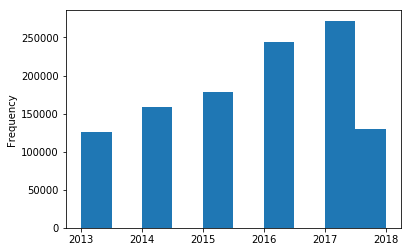

In [5]:
print("Unique Project Statuses", projects_df['Project Current Status'].unique())
projects_df["Posted Year"].plot(kind='hist')

#### <font color="blue">1.4 Find record counts for Project Current Status Column</font> 
We need to identify the record count associated with project current status.

In [6]:
print(projects_df[["Project ID", 'Project Current Status']].groupby('Project Current Status').count())

                        Project ID
Project Current Status            
Expired                     241402
Fully Funded                826764
Live                         41851


#### <font color="blue">1.5 Pick records with Project Current Status Column with Live values</font> 
The user is presented with live projects and this project is being done with the sole purpose of presenting the users with associated projects. Here we picking up projects which have project current status  as live.

In [7]:
active_projects_df=projects_df[projects_df['Project Current Status']=='Live']
active_projects_df.reset_index(inplace=True)
del projects_df
gc.collect()
print("size of active project", active_projects_df.shape)

size of active project (41851, 23)


#### <font color="blue">1.6 verify that column Project Essay has correct number of records with Project Current Status Column with Live values</font> 
The number of records with project essay is consistent with total records with project current status as live

In [8]:
print(active_projects_df[["Project Essay", 'Project Current Status']].groupby('Project Current Status').count())

                        Project Essay
Project Current Status               
Live                            41851


#### <font color="blue">1.7 Display the number of years spanned by the records with project current status</font>

Display the number of year spanned by records having project current status as live 

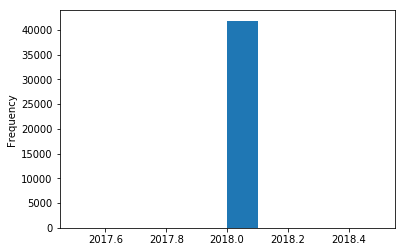

In [9]:
active_projects_df["Posted Year"].plot(kind='hist')

#### <font color="blue">1.8 Derive all the values of project essay column </font>

Derive the project essay column values to be used for cosine similarity

In [10]:
project_essay = active_projects_df['Project Essay'].values
print(project_essay[:1])

[ "My students are Special Education Math Middle School Students. I have 3 classes of students (one for each grade level 6-8). These students have several stumbling blocks in front of them and a public education shouldn't be one of them.  They need so much more than Computers, but I am starting with an essential and will make do without the rest. If it was not a violation of FERPA, I would post a picture of all of my students.   Theses students are a handful at this age.  Letting them share the few computers in class is challenging, having more computers available would ensure each child has adequate time to complete lessons daily.  <!--DONOTREMOVEESSAYDIVIDER-->This project will make a difference in the education of all of my students learning process and solve several behavior related issues due to sharing a few classroom computers.  My students need equal computer learning time! They deserve more than the public education they are enrolled in can provide.  Smaller classrooms with lo

 #### <font color="blue">1.8 Train project essay values </font>

Using TfidfVectorizer train the project_essay values to derive tfidf_matrix

In [11]:
vectorizer = TfidfVectorizer(strip_accents='unicode', 
                     analyzer='word', 
                     lowercase=True, # Convert all uppercase to lowercase
                     stop_words='english', # Remove common English words
                     max_df = 0.9)
tfidf_matrix =  vectorizer.fit_transform(project_essay)

 #### <font color="blue">1.9 Utility method to derive the project id </font>

Given an index, the method identifies the project id associated with this index

In [12]:
def get_project_id(index):
    return active_projects_df.at[index,  'Project ID']

 #### <font color="blue">2.0 Constants declarations </font>

The constants declaration

In [13]:
# This will be used to derive the related projects dataframe
output_columns=['Project ID', 'Related Project ID', 'Cosine Similarity'] 
# This is representative of top n projects defaults to 5. Changeable to any useful value 
top_n = 5
#number of partitions to split dataframe
num_partitions = 4
#number of cores on your machine
num_cores = 2
# round off digits for cosine similarity score
round_digits=2

 #### <font color="blue">2.1 Given an index, this function will return all the related projects</font>

Given an index as a parameter, this function will return all the related projects using the tfidf_matrix derived earlier


In [14]:
def get_similar_projects(index):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    list_data=[(get_project_id(index), get_project_id(row_index), round(cosine_similarities[row_index], round_digits)) for row_index in related_docs_indices][0:top_n]
    return list_data

 #### <font color="blue">2.2 Given a DataFrame, it iterates thru the rows to derive the related projects  </font>

Given a DataFrame, it iterates thru the rows to derive the related projects. This is utilized in the context of paritioning the dataframe and process them independently

In [15]:
def find_similar_projects(data_frame):
    output =[]
# Note here the number of records processed is limited to 200 for the purpose of this submission. 
#     for index in tqdm(data_frame.index.values.tolist()):    
    for index in tqdm(data_frame.index.values[:200]):
        project_list=get_similar_projects(index)
        output.extend(project_list)
    return pd.DataFrame(output, columns=output_columns)

 #### <font color="blue">2.3 The function will parallel process the dataframe </font>

The function will parallel process the dataframe by partioning it and process them parallely using multiprocessing pool

In [16]:
def parallel_process_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

 #### <font color="blue">2.4 This procedure invokes paralel processing of dataframe</font>

This procedure invokes paralel processing of dataframe by passing active_projects_df and the function name to used for parallel processing to derive the related projects

In [17]:
related_projects_df = parallel_process_dataframe(active_projects_df, find_similar_projects)
print(related_projects_df.shape)
print(related_projects_df.head(20))

100%|██████████| 200/200 [02:32<00:00,  1.38it/s]


(4000, 3)
                          Project ID                Related Project ID  Cosine Similarity
0   486b625006d71ab21f8592463608e42d  78a42721004734c94ff1a4d0d118365c               0.35
1   486b625006d71ab21f8592463608e42d  51c1892a679be303cf9fc7e2b5a00ef0               0.35
2   486b625006d71ab21f8592463608e42d  6dab3d09d42c37a10a8842e9d6b3e40d               0.35
3   486b625006d71ab21f8592463608e42d  f66ab60ed55c25ef6b1f6ce14d7cb342               0.34
4   486b625006d71ab21f8592463608e42d  785f90f2228eb19c83f7b2e3638ca888               0.33
5   d386d5f58d0388b62b7a7b06e99d1afb  90388cc252d97ed91446b56562b9e3f9               0.31
6   d386d5f58d0388b62b7a7b06e99d1afb  67ac18693559e72c195c22eada4ac3c1               0.27
7   d386d5f58d0388b62b7a7b06e99d1afb  1472ec80dbe3642cd3c6d579b25946c0               0.25
8   d386d5f58d0388b62b7a7b06e99d1afb  e32251cf79b3bb2f2cdc55350b5b459a               0.25
9   d386d5f58d0388b62b7a7b06e99d1afb  f5011a9816695807c8990af6618a44f8               0.24


 #### <font color="blue">2.5 Peristence of related projects data frame</font>

This will save the derived related projects as a file. However, in real life situations, it can be persisted in a database

In [18]:
related_projects_df.to_csv(path +"Related Projects.csv")

 #### <font color="blue">2.6 Merging of active_projects_df with related_projects_df </font>

Merging of active_projects_df with related_projects_df to derive the overall dataset to show related projects in the context of projects dataframe

In [19]:
merged_df=active_projects_df.merge( related_projects_df, on='Project ID', how='inner')

 #### <font color="blue">2.7 Watermark the crieria for cosine similarity </font>

It is possible to watermark the crireia for cosine similarity and the resulting dataset can be persisted with database.

In [20]:
merged_df[merged_df['Cosine Similarity'] > 0.7]

,index,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date,cost,Posted Date,Posted Year,Posted Month,Related Project ID,Cosine Similarity
15,1045742,af65b9205616bd482d94de31648d6cd1,a32fcd039389bde710c4c648e326fcd9,3dfc673e3d9f2b0fdce11431b3923a7c,3,Teacher-Led,Help Us Get Our Apps Together!,As a teacher in a low-income/high poverty scho...,As a teacher in a low-income/high poverty scho...,My students need access to one on one iPad opp...,"Literacy & Language, Special Needs","Literacy, Special Needs",Grades PreK-2,Computers & Tablets,490.53,2018-03-28,2018-07-28,Live,NaN,490.53,2018-03-28,2018,3,44835355fcbab1721d49be26cb7dad31,0.90
80,1045769,7213bfdd20378d5650a6b4392fa479ae,a0b70d8c096f3158efef161a346abdd9,5bb78aa64eb0d9ea25a25f4d8e17840a,3,Teacher-Led,Help Us Move and Work at the Same Time!,Many students in my school speak English as a ...,Many students in my school speak English as a ...,My students need alternative seating to help t...,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Grades 3-5,Flexible Seating,582.78,2018-03-28,2018-07-28,Live,NaN,582.78,2018-03-28,2018,3,cb43dfe36a77824fb82b77314eea2d2e,0.79
85,1045771,daec5070579ef925d822a26f6d65f858,c2cd7d6684f89f0911a966401fba9d97,6552592608bfd57ac01ae0d4866d6d07,10,Teacher-Led,Ants In Our Pants!,My students are amazing and I couldn't have as...,My students are amazing and I couldn't have as...,My students need flex comfy floor seats and so...,Applied Learning,Other,Grades PreK-2,"Reading Nooks, Desks & Storage",494.04,2018-03-28,2018-07-28,Live,NaN,494.04,2018-03-28,2018,3,ec8b31af11c2560d8fca5a698bc29946,1.00
86,1045771,daec5070579ef925d822a26f6d65f858,c2cd7d6684f89f0911a966401fba9d97,6552592608bfd57ac01ae0d4866d6d07,10,Teacher-Led,Ants In Our Pants!,My students are amazing and I couldn't have as...,My students are amazing and I couldn't have as...,My students need flex comfy floor seats and so...,Applied Learning,Other,Grades PreK-2,"Reading Nooks, Desks & Storage",494.04,2018-03-28,2018-07-28,Live,NaN,494.04,2018-03-28,2018,3,208779376c99dc6692a5fb3489d122f0,0.98
135,1045783,78b74969552b1484f24859eddb871bb0,50d2c1791fe35e24ebc1b27be4576910,dd7e9b70acf5f97d3da5e69cd3299dbb,20,Teacher-Led,Student's with Autism Learn Social Skills thro...,"I teach students in 3rd, 4th, 5th and 6th grad...","I teach students in 3rd, 4th, 5th and 6th grad...",My students need the LEGO Education Community ...,"History & Civics, Special Needs","Social Sciences, Special Needs",Grades 3-5,Books,525.76,2018-03-28,2018-07-28,Live,NaN,525.76,2018-03-28,2018,3,7c0cbe3b9df650d364a2a96ce744c091,0.92
136,1045783,78b74969552b1484f24859eddb871bb0,50d2c1791fe35e24ebc1b27be4576910,dd7e9b70acf5f97d3da5e69cd3299dbb,20,Teacher-Led,Student's with Autism Learn Social Skills thro...,"I teach students in 3rd, 4th, 5th and 6th grad...","I teach students in 3rd, 4th, 5th and 6th grad...",My students need the LEGO Education Community ...,"History & Civics, Special Needs","Social Sciences, Special Needs",Grades 3-5,Books,525.76,2018-03-28,2018-07-28,Live,NaN,525.76,2018-03-28,2018,3,51e0dd5bbc099bdfc7d2342d15ce37ef,0.78
230,1045819,cd629b3e3a2b656922303f3b4b279184,961dd7f681f17b4329c4b35dcf875740,0cec7bc542967be06f547b9bf6f598b6,39,Teacher-Led,Readers Are Leaders!,A new year and a new set of eager learners. I ...,A new year and a new set of eager learners. I ...,My students need leveled fiction and nonfictio...,Literacy & Language,"Literacy, Literature & Writing",Grades PreK-2,Books,472.45,2018-03-28,2018-07-28,Live,NaN,472.45,2018-03-28,2018,3,3d1fb4cb014b657aebc310a09d707b4c,0.99
240,1045821,d951a7b56664f020352bff5f80427467,d1819e35de1aa9d2f6607daa69672ec1,5e9d746

#### <font color="blue">2.8 Cosine Similarity Verification</font>
I came across a cosine similarity score of 1.0 with merged_df dataframe  with a project id of daec5070579ef925d822a26f6d65f858 with a related project id of ec8b31af11c2560d8fca5a698bc29946. I was curious to find out if this score is really correct. I find that the project essay has been created by the same teacher for two different resource requirements on the same date using the same project essay. This establishes that the alogorithm employed is correct

In [21]:
set_pd_options()
pd.set_option('display.max_colwidth', -1)
query_columns = ["Project Essay","Teacher ID","Project Title", \
                  "Project Need Statement", "Project Resource Category", \
                  "Project Cost", "Project Posted Date"]
print(active_projects_df[active_projects_df["Project ID"]=="daec5070579ef925d822a26f6d65f858"][query_columns])

In [22]:
set_pd_options()
pd.set_option('display.max_colwidth', -1)
print(active_projects_df[active_projects_df["Project ID"]=="ec8b31af11c2560d8fca5a698bc29946"][query_columns])

#### <font color="blue">1.1 Reset Panda Options</font> 
Utility method for resetting panda options.

In [23]:
def reset_pd_options():
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

### <font color="blue">End Notes</font>

In this implementation, I have researched different approaches to tackle the problem statement. During this process, I gathered  different ideas from internet  resources & my own thought process. I have referenced relevant articles utilized in the section below.

The references are given below: <br>
https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/ <br>
https://courses.cs.washington.edu/courses/cse573/12sp/lectures/17-ir.pdf <br>
http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/ <br>
https://markhneedham.com/blog/2016/07/27/scitkit-learn-tfidf-and-cosine-similarity-for-computer-science-papers/ <br>
https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/ <br>
http://www.racketracer.com/2016/07/06/pandas-in-parallel/<br>
